In [69]:
import numpy as np
import pandas as pd

from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.svm import LinearSVR
from sklearn.svm import SVR

from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
%matplotlib inline
from collections import namedtuple

In [70]:
ORIGIN_BLOCKGROUP = 'o_bg'
GEO_ID = 'geoid'
AREA = 'area'
BLOCKGROUP_MODE_CHOICE = 'block_group'
BLOCKGROUP_AFFORDABILITY = 'key'
BLOCKGROUP = 'blockgroup'


### The following is new features list
DURATION = 'google_duration'
DISTANCE = 'trip_path_distance'
HOUSEHOLD_SIZE = 'hhsize'
RENT = 'hh_rent'
HOME_OWN = 'hh_own'
DEPART_TIME = 'depart_time'
NUMBER_CHILDREN = 'numchildren'
NUMBER_VEHICLE = 'vehicle_count'
FEMALE = 'gender_female'
MALE = 'gender_male'
WEEKDAY_AM = 'weekday_am'
WEEKDAY_MID = 'weekday_mid'
WEEKDAY_PM = 'weekday_pm'
WEEKDAY_LATE = 'weekday_late'
RESIDENCY_UNDER5 = 'residency_under5'
RESIDENCY_OVER5 = 'residency_over5'
INCOME_UNDER25 = 'income_under25'
INCOME_75_100 = 'income_75_100'
INCOME_OVER100 = 'income_over100'
RACE_WHITE = 'race_white'
TRIP_WEIGHT = 'trip_weight_revised'
DRIVE_ALONE_THRESHOLD = 'drive_alone_threshold'
DRIVE_ALONE = 'drive_alone'
###

# and TRIP_WEIGHT when summarizing the results
WEIGHTED_VALUES = 'weighted_values'

#rename:
MODE_INDEX = 'mode_index'
SCALED = 'scaled'
MODE_CHOIDE_SCORE = 'mode_choice_score'
AFFORDABILITY_SCORE = 'affordability_score'
ABOVE_MEDIAN = 'prop_driving_above_median'
RELATIVE_SCALED = 'relative_scaled'

FEATURES_LIST = [DURATION, DISTANCE, HOUSEHOLD_SIZE, RENT, HOME_OWN, DEPART_TIME, 
                NUMBER_CHILDREN, NUMBER_VEHICLE, FEMALE, MALE, 
                WEEKDAY_AM, WEEKDAY_MID, WEEKDAY_PM, WEEKDAY_LATE, 
                RESIDENCY_UNDER5, RESIDENCY_OVER5, INCOME_UNDER25, INCOME_75_100, INCOME_OVER100, 
                RACE_WHITE, TRIP_WEIGHT]
SCORES_LIST = [MODE_CHOIDE_SCORE, AFFORDABILITY_SCORE]
OUTCOME_LIST = [DRIVE_ALONE, DRIVE_ALONE_THRESHOLD]

In [71]:
tr = pd.read_csv('df_Trip_Features.csv', dtype={ORIGIN_BLOCKGROUP: str})
tr.rename(columns={ORIGIN_BLOCKGROUP: BLOCKGROUP}, inplace=True)
tr.head()
len(tr[BLOCKGROUP].unique())

152

In [72]:
# load features/covariates and normalize the values

mode_choice = pd.read_csv('true_final/final_mode_choice_081418.csv', 
                          dtype={BLOCKGROUP_MODE_CHOICE: 'str'})[[BLOCKGROUP_MODE_CHOICE, MODE_INDEX]]
mode_choice.rename(columns = {BLOCKGROUP_MODE_CHOICE: BLOCKGROUP, 
                              MODE_INDEX: MODE_CHOIDE_SCORE}, inplace=True)


affordability = pd.read_csv('true_final/final_affordability_081418.csv', 
                            dtype={BLOCKGROUP_AFFORDABILITY: 'str'})[[BLOCKGROUP_AFFORDABILITY, RELATIVE_SCALED]]
affordability.rename(columns = {BLOCKGROUP_AFFORDABILITY: BLOCKGROUP, 
                               RELATIVE_SCALED: AFFORDABILITY_SCORE}, inplace=True)

In [73]:
features_set = pd.merge(left=mode_choice, right=affordability, on=BLOCKGROUP)
features_set.head()

,blockgroup,mode_choice_score,affordability_score
0,530330100023,0.781429,0.339924
1,530330107023,0.691429,0.454073
2,530330110013,0.654286,0.104318
3,530330020003,0.794286,0.539485
4,530330080015,0.801429,0.636726


Now we should be ready for Prediction

In [74]:
def fit_and_evaluate_continuous(input_model, title_label, input_dat, output_dat, scoring_method):
    
    """
    This function runs linear regression, random forests regression, support vector regression
    using continuous outcome
    """
    
    input_model.fit(input_dat, output_dat)
    mode_scores = cross_val_score(input_model, input_dat, output_dat, scoring=scoring_method, cv=5)

    print("the next are " + scoring_method + " for each K")
    print(np.abs(mode_scores))
    print(scoring_method + " (Average / Std): %0.2f (+/- %0.2f)" % 
          (np.abs(mode_scores).mean(), np.abs(mode_scores).std() * 2) + "\n")
    
def fit_and_evaluate_binary(input_model, title_label, input_dat, output_dat):
    
    """
    This function runs logistic regression, random forests classifier, support vector classifier
    using binary outcome
    """    
    
    input_model.fit(input_dat, output_dat)
    mode_scores = cross_val_score(input_model, input_dat, 
                              output_dat, 
                              scoring='accuracy', cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0))

    #print("Accuracy for each K")
    #print(np.abs(mode_scores), "\n")
    print("Summary: " + title_label + " with 5-fold CV Accuracy: %0.2f (+/- %0.2f)" % 
          (np.abs(mode_scores).mean(), np.abs(mode_scores).std() * 2))
    print("\n")
    
    return ([np.abs(mode_scores).mean(), np.abs(mode_scores).std()])

In [75]:
def run_and_diagnose(input_scores, input_psrc, output_binary_dat, score_title, psrc_title):
    
    """
    This function applies three classification methods to the two different models;
    1. Mode Choice & Affordability => Driving Alone (binary)
    2. All available PSRC raw features => Driving Alone (binary)
    and then print the accuracy of prediction results and draw plots. 
    """
    
    n_groups = 3

    logreg_score = fit_and_evaluate_binary(LogisticRegression(), 
                        score_title + " Logistidc Regression", input_scores, output_binary_dat)
    rfc_score = fit_and_evaluate_binary(RandomForestClassifier(max_depth=100, random_state=0), 
                               score_title + " Random Forest Classifier", input_scores, output_binary_dat)
    svc_score = fit_and_evaluate_binary(LinearSVC(), 
                        score_title + " Support Vector Classifier with Linear Kernel", input_scores, output_binary_dat)
    score_means = list(zip(logreg_score, rfc_score, svc_score))[0]
    score_vars = list(zip(logreg_score, rfc_score, svc_score))[1]


    logreg_psrc = fit_and_evaluate_binary(LogisticRegression(), 
                        psrc_title + " Logistidc Regression", input_psrc, output_binary_dat)
    rfc_psrc = fit_and_evaluate_binary(RandomForestClassifier(max_depth=100, random_state=0), 
                        psrc_title + " Random Forest Classifier", input_psrc, output_binary_dat)
    svc_psrc = fit_and_evaluate_binary(LinearSVC(), 
                        psrc_title + " Support Vector Classifier with Linear Kernel", input_psrc, output_binary_dat)
    psrc_means = list(zip(logreg_psrc, rfc_psrc, svc_psrc))[0]
    psrc_vars = list(zip(logreg_psrc, rfc_psrc, svc_psrc))[1]


    # The following draws a grouped bar plot comparing different algorithms & models
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35

    opacity = 0.4
    error_config = {'ecolor': '0.3'}

    rects1 = ax.bar(index, score_means, bar_width,
                alpha=opacity, color='b',
                yerr=score_vars, error_kw=error_config,
                label=score_title)


    rects2 = ax.bar(index + bar_width, psrc_means, bar_width,
                alpha=opacity, color='r',
                yerr=psrc_vars, error_kw=error_config,
                label=psrc_title)

    #ax.set_xlabel('Group')
    ax.set_ylabel('Accuracy')
    ax.set_title(score_title + " vs. " + psrc_title + " Accuracy Comparison")
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(('Logistic Regression', 'Random Forest', 'Support Vector Classifier'))
    ax.legend(loc=9, bbox_to_anchor=(0.5, -0.1))

    fig.tight_layout()
    plt.show()
    
    idx_column = ['logistic', 'randomforest', 'svc']
    
    score_means = pd.Series(score_means, index = idx_column)
    psrc_means = pd.Series(psrc_means, index = idx_column)

    res = pd.DataFrame({score_title: score_means, psrc_title:psrc_means})
    return(res)

In [76]:
merged = pd.merge(left=features_set, right=tr, how='inner', on=BLOCKGROUP)
merged.set_index(BLOCKGROUP, inplace=True)

# normalize data except the binary outcome
normalized_merged = merged[[DRIVE_ALONE, DRIVE_ALONE_THRESHOLD]].copy()
normalized_merged[FEATURES_LIST] = (merged[FEATURES_LIST]- merged[FEATURES_LIST].mean()) / merged[FEATURES_LIST].std()
normalized_merged[SCORES_LIST] = (merged[SCORES_LIST]- merged[SCORES_LIST].mean()) / merged[SCORES_LIST].std()
normalized_merged[DRIVE_ALONE] = (merged[DRIVE_ALONE]- merged[DRIVE_ALONE].mean()) / merged[DRIVE_ALONE].std()
normalized_merged.head()

,drive_alone,drive_alone_threshold,google_duration,trip_path_distance,hhsize,hh_rent,hh_own,depart_time,numchildren,vehicle_count,gender_female,gender_male,weekday_am,weekday_mid,weekday_pm,weekday_late,residency_under5,residency_over5,income_under25,income_75_100,income_over100,race_white,trip_weight_revised,mode_choice_score,affordability_score
blockgroup,,,,,,,,,,,,,,,,,,,,,,,,,
530330110013,2.525521,0,0.743689,2.396771,2.079961,-1.250570,1.344633,-1.470015,-0.696181,1.976021,0.131416,0.304800,0.065429,1.323502,-1.340972,-0.838021,-1.154259,1.154259,3.844520,-0.342820,-1.569614,-2.792357,-0.264608,-1.560704,-2.112169
530330080015,-0.943396,1,-1.330210,-1.197466,-1.247744,1.176548,-1.118038,0.358793,-0.913947,-1.648598,0.092740,0.174694,0.289594,-0.484281,-0.042519,1.275059,1.054215,-1.054215,-0.729014,-0.346759,1.223102,0.696367,-0.352647,0.580034,0.756848
530330053021,-1.252253,1,2.150241,-0.847011,-0.353071,0.160256,-0.086859,-0.039045,-0.741645,-0.056592,-1.188830,1.220628,-0.193450,0.320981,0.386810,-0.685899,1.362798,-1.362798,0.724442,1.286995,-1.649176,0.338181,-0.220513,0.580034,-0.352743
530330061003,1.370112,0,-1.067674,-0.201785,1.599153,-1.577192,1.676040,-0.617915,-0.913947,3.246065,-0.946994,1.297115,0.260654,0.063688,0.269387,-0.863675,-1.649507,1.649507,-0.729014,-0.346542,1.461926,0.173920,-0.164469,1.400996,0.518253
530330081003,-0.472366,1,-0.069276,-0.362324,-0.182501,-0.861215,0.933208,0.786302,-0.635669,-0.284397,0.505773,-0.058642,-0.916681,-0.346497,1.595214,-0.670738,0.777790,-0.777790,-0.131110,-0.217322,-0.932566,0.818130,0.171085,1.006103,1.210647


Summary: ModeChoice & Affordability Logistidc Regression with 5-fold CV Accuracy: 0.71 (+/- 0.06)


Summary: ModeChoice & Affordability Random Forest Classifier with 5-fold CV Accuracy: 0.68 (+/- 0.10)


Summary: ModeChoice & Affordability Support Vector Classifier with Linear Kernel with 5-fold CV Accuracy: 0.72 (+/- 0.05)


Summary: Raw PSRC Logistidc Regression with 5-fold CV Accuracy: 0.78 (+/- 0.17)


Summary: Raw PSRC Random Forest Classifier with 5-fold CV Accuracy: 0.74 (+/- 0.12)


Summary: Raw PSRC Support Vector Classifier with Linear Kernel with 5-fold CV Accuracy: 0.80 (+/- 0.14)




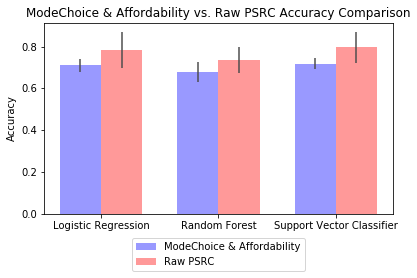

,ModeChoice & Affordability,Raw PSRC
logistic,0.710619,0.782477
randomforest,0.678161,0.737775
svc,0.717071,0.795825


In [77]:
# Now run the result
run_and_diagnose(normalized_merged[SCORES_LIST], normalized_merged[FEATURES_LIST], normalized_merged[DRIVE_ALONE_THRESHOLD], 
                'ModeChoice & Affordability', 'Raw PSRC')

In [54]:
from sklearn.pipeline import Pipeline

In [58]:
# to examine principal components
pca=PCA(n_components=4)
#pca.fit(normalized_res) 
#print(pca.components_)
pca.fit_transform(tr[FEATURES_LIST].values)
print(pca.explained_variance_ratio_)

pd.set_option('display.max_columns', 30)
pd.DataFrame(pca.components_, columns=tr[FEATURES_LIST].columns, index = ['PC-1','PC-2', 'PC-3', 'PC-4'])

[  9.99999975e-01   1.69606964e-08   4.80954545e-09   1.51232658e-09]


,google_duration,trip_path_distance,hhsize,hh_rent,hh_own,depart_time,numchildren,vehicle_count,gender_female,gender_male,weekday_am,weekday_mid,weekday_pm,weekday_late,residency_under5,residency_over5,income_under25,income_75_100,income_over100,race_white,trip_weight_revised
PC-1,-0.000025,-0.000007,0.000007,-0.000001,0.000001,0.000010,0.000006,0.000002,-4.124836e-07,-8.320874e-07,-0.000001,0.000001,5.740983e-07,-1.183770e-07,0.000001,-0.000001,-6.518287e-07,1.080029e-08,0.000001,-4.330212e-07,1.000000
PC-2,0.968114,0.249162,-0.006402,-0.003769,0.004258,-0.010315,-0.010179,0.010133,6.352691e-04,-1.103391e-03,-0.001946,0.004811,-1.356995e-03,-2.433652e-03,0.007926,-0.007926,5.212798e-03,1.581522e-03,-0.009715,8.330634e-04,0.000026
PC-3,-0.017125,0.026493,0.049059,-0.010250,0.016152,-0.990424,0.012802,0.059644,1.070124e-02,-1.609949e-02,0.062844,0.003204,-6.413889e-02,-2.020621e-02,-0.033497,0.033497,-6.306110e-03,3.453043e-03,-0.001622,-2.041622e-02,0.000009
PC-4,-0.182119,0.720377,0.394737,-0.160340,0.152645,0.081387,0.233727,0.378152,2.364079e-02,-6.150694e-02,0.005971,-0.006418,2.338022e-02,-1.347604e-02,-0.114870,0.114870,-3.913967e-02,5.528789e-03,0.051240,-5.556031e-02,-0.000005


Summary: ModeChoice & Affordability Logistidc Regression with 5-fold CV Accuracy: 0.71 (+/- 0.06)


Summary: ModeChoice & Affordability Random Forest Classifier with 5-fold CV Accuracy: 0.68 (+/- 0.10)


Summary: ModeChoice & Affordability Support Vector Classifier with Linear Kernel with 5-fold CV Accuracy: 0.72 (+/- 0.05)


Summary: Raw PSRC (Five Features) Logistidc Regression with 5-fold CV Accuracy: 0.82 (+/- 0.09)


Summary: Raw PSRC (Five Features) Random Forest Classifier with 5-fold CV Accuracy: 0.78 (+/- 0.10)


Summary: Raw PSRC (Five Features) Support Vector Classifier with Linear Kernel with 5-fold CV Accuracy: 0.82 (+/- 0.09)




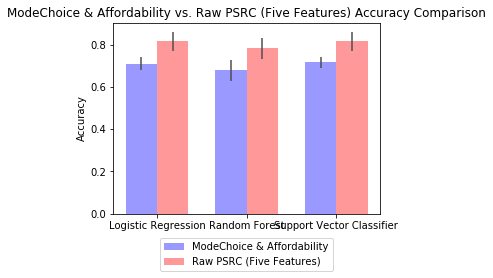

,ModeChoice & Affordability,Raw PSRC (Five Features)
logistic,0.710619,0.815825
randomforest,0.678161,0.782937
svc,0.717071,0.815825


In [79]:
FEATURES_LIST2 = [DURATION, DISTANCE, HOUSEHOLD_SIZE, NUMBER_VEHICLE, HOME_OWN]
run_and_diagnose(normalized_merged[SCORES_LIST], normalized_merged[FEATURES_LIST2], normalized_merged[DRIVE_ALONE_THRESHOLD], 
                'ModeChoice & Affordability', 'Raw PSRC (Five Features)')

Summary: PSRC five Logistidc Regression with 5-fold CV Accuracy: 0.78 (+/- 0.06)


Summary: PSRC five Random Forest Classifier with 5-fold CV Accuracy: 0.71 (+/- 0.07)


Summary: PSRC five Support Vector Classifier with Linear Kernel with 5-fold CV Accuracy: 0.76 (+/- 0.06)


Summary: PSRC Five Logistidc Regression with 5-fold CV Accuracy: 0.79 (+/- 0.07)


Summary: PSRC Five Random Forest Classifier with 5-fold CV Accuracy: 0.75 (+/- 0.19)


Summary: PSRC Five Support Vector Classifier with Linear Kernel with 5-fold CV Accuracy: 0.80 (+/- 0.09)




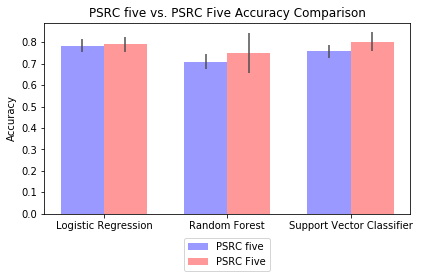

,PSRC Five,PSRC five
logistic,0.790248,0.783352
randomforest,0.750204,0.710174
svc,0.802937,0.757115


In [25]:
# This shows Feature list + scores perform the best
run_and_diagnose(normalized_merged[SCORES_LIST], 
                 normalized_merged[FEATURES_LIST2], normalized_merged[DRIVE_ALONE_THRESHOLD], 
                'PSRC five', 'PSRC Five')

In [106]:
# we may use and modify the following if we want Altair plots..
"""
import altair as alt
from altair.expr import datum, if_
from vega_datasets import data

source = data.population.url

alt.Chart(source).mark_bar(stroke='transparent').encode(
    alt.X('gender:N', scale=alt.Scale(rangeStep=12), axis=alt.Axis(title='')),
    alt.Y('sum(people):Q', axis=alt.Axis(title='population', grid=False)),
    color=alt.Color('gender:N', scale=alt.Scale(range=["#EA98D2", "#659CCA"])),
    column='age:O'
).configure_view(
    stroke='transparent'
).configure_axis(
    domainWidth=0.8
).transform_filter(
    datum.year == 2000
).transform_calculate(
    'gender', if_(datum.sex == 2, 'Female', 'Male')
)
"""

'\nimport altair as alt\nfrom altair.expr import datum, if_\nfrom vega_datasets import data\n\nsource = data.population.url\n\nalt.Chart(source).mark_bar(stroke=\'transparent\').encode(\n    alt.X(\'gender:N\', scale=alt.Scale(rangeStep=12), axis=alt.Axis(title=\'\')),\n    alt.Y(\'sum(people):Q\', axis=alt.Axis(title=\'population\', grid=False)),\n    color=alt.Color(\'gender:N\', scale=alt.Scale(range=["#EA98D2", "#659CCA"])),\n    column=\'age:O\'\n).configure_view(\n    stroke=\'transparent\'\n).configure_axis(\n    domainWidth=0.8\n).transform_filter(\n    datum.year == 2000\n).transform_calculate(\n    \'gender\', if_(datum.sex == 2, \'Female\', \'Male\')\n)\n'